# Problem Set 2

## Important information

Please submit the single Jupyter Notebook file, where only Python and Markdown/LaTeX are used. Any hand-written solutions inserted by photos or in any other way are prohibitive and will not be graded. If you will have any questions about using Markdown, ask them!

The works will be checked for plagiarism. The score will be divided by the number of similar works.

## Tensor Train (10 pts)

**Tensor** is a multidimensional array of shape $n_1 \times n_2 \times ... \times n_d$ where the number $d$ defines the dimensionality and every element can be get trough a multi-index $[i_1, i_2, \dots, i_d]$. If $d=1$ such tensor is simply a vector and if $d=2$ it is a $n_1 \times n_2$ matrix.

**Tensor Train** is a special tensor representation form that enables to efficently store high-dimensional tensors and perform mathematical operation with them. It was proposed in [link](https://www.researchgate.net/profile/Ivan-Oseledets/publication/220412263_Tensor-Train_Decomposition/links/5bbfb5c5299bf1004c5a56e3/Tensor-Train-Decomposition.pdf). Basically instead of storing all tensor entries $A[1_1, i_2, \dots, i_d]$ it was proposed to use a factorization trough specific 3D-tensors $G_i$ of shape $r_{i-1} \times n_i \times r_i$ that are called **cores**. Any entry $A[1_1, i_2, \dots, i_d]$ of tensor A can thus be computed as:

$$
A[i_1, i_2, \dots, i_d] =
\sum_{\alpha_0=1}^{r_0}
\sum_{\alpha_1=1}^{r_1}
\dots
\sum_{\alpha_d=1}^{r_d}
G_1[\alpha_0, i_1, \alpha_1] \; \cdot
G_2[\alpha_1, i_2, \alpha_2] \; \cdot
\dots \; \cdot
G_d[\alpha_{d-1}, i_d, \alpha_d],
$$

The numbers $r_i$ are are chosen during construction and called **ranks** of the representation:
1. boundary ranks $r_0 = r_N = 1$, ensuring the summation collapses to a scalar.
2. small ranks $r_i$ make the representation compact and memory efficient but increase the approximation error

TT decomposition is a generalization of matrix factorizations like SVD to higher dimensions, adapted for tensors.

### Tensor Train Construction

To construct the cores one needs to perform a TT-SVD algorithm: we start from $C_1 = A$ and then for every $k$ from 1 to $d$ we perform following steps untill we get all the cores:
1. Unfold matrix $C_k = C_k.reshape(r_{k-1} n_k, \prod_{i=k+1}^{d} n_i)$.
2. Perform a low-rank SVD for $C_k$ and get the matrices $U_k, \Sigma_k, V_k^*$ with rank $r_k <= \text{rank}(C_k)$.
3. Compute the core $G_k = U_k.reshape(r_{k-1}, n_k, r_k)$.
4. Update the matrix $C_{k+1} = \Sigma_k V_k^*$.

**Task (10 pts):** Realize TT-SVD for $d$-dimensional tensor and check it for a random tensor.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def tt_svd(tensor, max_rank=10):
    """
    Convert a tensor into a tensor train.
    input : tensor - np.array of shape [n_1, n_2, ..., n_d]
            max_rank - maximal number that ranks r_0, ..., r_d can reach
    output: cores - list of d np.arrays of shape [r_i-1, n_i, r_i] for i in d
    """
    n = A.shape
    d = len(n)
    cores = []
    r_prev = 1
    C = A

    for k in range(d - 1):
        C = C.reshape(r_prev * n[k], -1)
        U, S, Vt = np.linalg.svd(C, full_matrices=False)
        r = min(max_rank, len(S))
        U, S, Vt = U[:, :r], S[:r], Vt[:r, :]
        G = U.reshape(r_prev, n[k], r)
        cores.append(G)
        C = np.diag(S) @ Vt
        r_prev = r

    G_final = C.reshape(r_prev, n[-1], 1)
    cores.append(G_final)

    return cores

To check your algorithm you need to take a function `tt_to_tensor` that converts a tensor train back into a tensor, run it for a tensor train $\mathcal{A}$ that you would get from your original tensor $A$, and compare $A$ and $A'$ in terms of low-rank approximation error and memory.

In [ ]:
def tt_to_tensor(cores):
    """
    Convert a tensor train into a tensor.
    input : cores - list of d np.arrays of shape [r_i-1, n_i, r_i] for i in d
    output: tensor - np.array of shape [n_1, ..., n_d]
    """
    tensor = cores[0]
    for G in cores[1:]:
        tensor = np.tensordot(tensor, G, 1)
    return tensor[0, ..., 0]

In [ ]:
d = 5
max_mode = 10
modes = np.random.randint(1, max_mode, size=(d))
A = np.random.randn(*modes)

error = []
memory = []
for max_rank in range(1, 50):
    A_tt = tt_svd(A, max_rank)
    A_recovered = tt_to_tensor(A_tt)

    error.append(np.linalg.norm(A_recovered - A))
    memory.append(sum([np.prod(core.shape) for core in A_tt]))

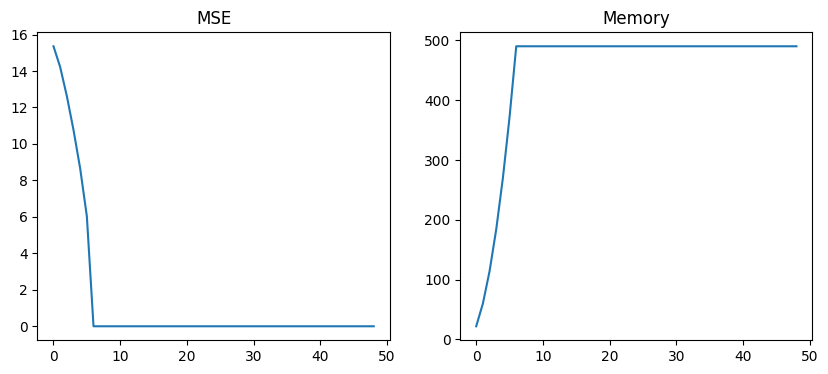

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('MSE')
plt.plot(error)

plt.subplot(1, 2, 2)
plt.title('Memory')
plt.plot(memory)

plt.show()

What can you say about the results?

Well, MSE quickly drops to 0 with almost the same speed as memory goes to plateau. Also we see that small ranks make method compact and memory efficient but with relatively big error. When rank increases more then we deal almost with accurate decomposition

## Sparce Matrix Factorization for Linear Systems (15 pts)

### Imports

In [ ]:
import numpy as np
import scipy.sparse as sp
import timeit
import scipy.sparse.linalg as spsplin
import scipy.linalg as splin
import matplotlib.pyplot as plt
import time
import networkx as nx
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
from IPython.display import HTML
from tqdm import tqdm
%matplotlib inline

In [ ]:
!apt-get install libsuitesparse-dev
!pip install scikit-sparse
!apt-get install -y ffmpeg imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libgraphblas-dev
  libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 librbio2 libsliplu1 libspqr2
  libsuitesparseconfig5 libumfpack5
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libgraphblas-dev
  libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 librbio2 libsliplu1 libspqr2
  libsuitesparse-dev libsuitesparseconfig5 libumfpack5
0 upgraded, 19 newly installed, 0 to remove and 49 not upgraded.
Need to get 22.4 MB of archives.
After this operation, 169 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.1

In [ ]:
from sksparse.cholmod import cholesky

### Demonstration: Fill-in importance

- Strictly regular matrices have LU-decomposition.

- An important **subclass** of strictly regular matrices is the class of **Hermitian positive definite matrices**


**Definition.** A matrix $A$ is called **positive definite** </font> if for any $x: \Vert x \Vert \ne 0$ we have

$$
(x, Ax) > 0.
$$

- **Claim:** A Hermitian positive definite matrix $A$ is strictly regular and has **Cholesky factorization** of the form

$$A = LL^*,$$

where $L$ is a lower triangular matrix.

Let us see how Cholesky is faster than LU in symmetric positive definite case. First demonstration is a random SPD matrix. The second one is the same matrix, but with its rows and columns permuted to reduce the fill-in.

In [ ]:
n = 3000
ex = np.ones(n)
A = sp.spdiags(np.vstack((3*ex,  7*ex, 3*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(3000,3000, density=(1/(10*n))).tocsr())
A = A+ S.transpose() + S

<ipython-input-10-337a3a82951b>:3: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(A, ordering_method="natural")


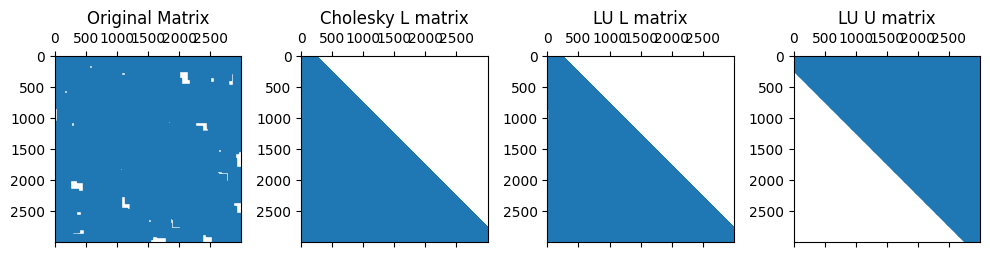

Cholesky time taken:  0.2253117561340332
LU time taken:  0.17472457885742188
Nonzero elements in original matrix:  9598
Nonzero elements in Cholesky L:  317501
Nonzero elements in LU L:  283210


In [ ]:
# Derive Cholesky Factorization
at = time.time()
factor = cholesky(A, ordering_method="natural")
bt = time.time()

# Derive LU Factorization
ct = time.time()
lu = spsplin.splu(A.tocsc(), permc_spec="NATURAL")
dt = time.time()

fig, axes = plt.subplots(1, 4, figsize=(10, 4))
axes[0].spy(A)
axes[0].set_title("Original Matrix")
axes[1].spy(factor.L())
axes[1].set_title("Cholesky L matrix")
axes[2].spy(lu.L)
axes[2].set_title("LU L matrix")
axes[3].spy(lu.U)
axes[3].set_title("LU U matrix")
plt.tight_layout()
plt.show()
print('==================================================')
print('Cholesky time taken: ', bt-at)
print('LU time taken: ', dt-ct)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)
print('Nonzero elements in LU L: ', lu.L.nnz)

<ipython-input-11-c3b80cb83397>:3: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(A)


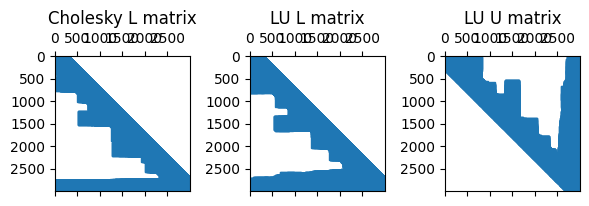

Cholesky time taken:  0.003448963165283203
LU time taken:  0.011449575424194336
Nonzero elements in original matrix:  9598
Nonzero elements in Cholesky L:  17670
Nonzero elements in LU L:  34506


In [ ]:
# Derive Cholesky Factorization
at = time.time()
factor = cholesky(A)
bt = time.time()

# Derive LU Factorization
ct = time.time()
lu = spsplin.splu(A.tocsc())
dt = time.time()

fig, axes = plt.subplots(1, 3, figsize=(6, 4))
axes[0].spy(factor.L())
axes[0].set_title("Cholesky L matrix")
axes[1].spy(lu.L)
axes[1].set_title("LU L matrix")
axes[2].spy(lu.U)
axes[2].set_title("LU U matrix")
plt.tight_layout()
plt.show()
print('==================================================')
print('Cholesky time taken: ', bt-at)
print('LU time taken: ', dt-ct)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)
print('Nonzero elements in LU L: ', lu.L.nnz)

### Nested dissection algorythm

As LU and Cholesky algorythms derive factors in a pre-defined order, we can permute matrix in a way to make this algorythms produce minimal fill-in. One of approaches that works with SPD matrices is reducing to **block arrowhead structure**.

$$
PAP^\top = \begin{bmatrix} A_{\alpha\alpha} & 0 & A_{\alpha\sigma} \\ 0 & A_{\beta\beta} & A_{\beta\sigma} \\ A_{\sigma\alpha} & A_{\sigma\beta} & A_{\sigma\sigma}\end{bmatrix}
$$

After decomposition, factors will have 0-blocks intact.

Main idea is that symmetric matrix $A$ can be seen as an adjacency matrix for some graph $G$. Then if we split $G$ into subgraphs $L, R, S$ in a way that there are no edges between nodes from $L$ and $R$, we can construct blocks, where node index is equal to matrix row/column index, and thus blocks $A_{LR}$ and $A_{RL}$ will be $0$.

The challenge in this approach is locating an optimal subset $S$ called **Separator** of nodes of $G$. **Separator** is a subgraph such that its removal splits the rest of the graph into two or more connected components.

Here we will choose separator using Spectral Partitioning approach (you can read about it in Lecture 11. Here is [a link](https://nla.skoltech.ru/lectures/lecture-11/lecture-11.html) to previous year's lecture if you want to see it sooner).

General algorythm is such:
1) Considering graph G based on given matrix A as an adjacency matrix for this graph, get the [Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix) of that graph.

2) Derive the eigenvector $w_2$ of graph's Laplacian that is corresponding to the second smallest eigenvalue.

3) Signs of components of $w_2$ define partitioning. Positive indexes define one class and negative - second class. These two classes are two connected components that will be left if we remove the separator class.

4) Derive indexes of Separator nodes - now we get indexes of all three classes $A, B, S$.

5) Permute matrix so rows and columns are ordered as $A, B, S$.

6) Iterate the same algorythm for blocks $A$ and $B$.

### Task 1 (5 pts): implement matrix separation

Implement given algorythm to permute matrix into lower-arrowhead block form (No recursion yet, we need only one split).

In [ ]:
def split_indices(partitioning, adjacency_matrix):
    alpha_indices = np.where(partitioning > 0)[0]
    beta_indices = np.where(partitioning <= 0)[0]

    row, col = adjacency_matrix.nonzero()
    neighbours_of_different_classes_ind = (partitioning[row] > 0) & (partitioning[col] <= 0)
    sep_indices = np.unique(col[np.where(neighbours_of_different_classes_ind)[0]])

    sep_indices = np.array(sep_indices)
    beta_indices = np.setdiff1d(beta_indices, sep_indices)
    return alpha_indices, beta_indices, sep_indices


def block_dissection(A):
  adjacency_matrix = A.copy()
  G = nx.Graph(adjacency_matrix)
  Laplacian = nx.laplacian_matrix(G).asfptype()

  eigval, eigvec = spsplin.eigsh(Laplacian, k=2, which="SM")
  partitioning = np.sign(eigvec[:, 1])

  alpha_indices, beta_indices, sep_indices = split_indices(partitioning, adjacency_matrix)
  order = np.concatenate([alpha_indices, beta_indices, sep_indices])
  adjacency_matrix = adjacency_matrix[order, :][:, order]
  return adjacency_matrix

In [ ]:
n = 300
k = 3
ex = np.ones(n)
A = sp.spdiags(np.vstack((2*ex,  8*ex, 2*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(n,n, density=(1/(k*n))).tocsr())
A = A + S.transpose() + S

In [ ]:
B = block_dissection(A)

<ipython-input-63-9dfa007eb88f>:17: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.14.0.
  Laplacian = nx.laplacian_matrix(G).asfptype()


<ipython-input-66-ceaf05168b0a>:6: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(B, ordering_method="natural")


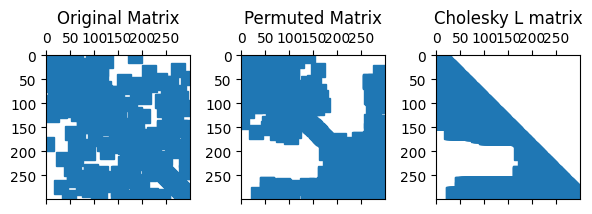

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(6, 4))
axes[0].spy(A)
axes[0].set_title("Original Matrix")
axes[1].spy(B)
axes[1].set_title("Permuted Matrix")
factor = cholesky(B, ordering_method="natural")
axes[2].spy(factor.L())
axes[2].set_title("Cholesky L matrix")
plt.tight_layout()
plt.show()

### Task 2 (5 pts): implement Nested Dissection



Now implement algorithm that will recursively permute each of $A_{iLL}$ and $A_{iRR}$ blocks to their own lower-arrowhead bock form.

Reminder: you are permuting the whole matrix, not each block separately.

Reminder: it is a good idea to move all $A_{iSS}$ blocks together on the bottom.

In [ ]:
n = 3000
k = 5
ex = np.ones(n)
A = sp.spdiags(np.vstack((1*ex,  3*ex, 1*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(n,n, density=(1/(k*n))).tocsr())
A = A+ S.transpose() + S

In [ ]:
lr = nested_dissection(A, 50)
s = np.setdiff1d(np.arange(A.shape[0]), lr)
order = np.concatenate((lr, s))
B = A[order, :][:, order]

<ipython-input-16-30824be0102e>:15: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.14.0.
  Laplacian = nx.laplacian_matrix(G).asfptype()


<ipython-input-69-e3d3b36b933f>:6: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factorA = cholesky(A, ordering_method="natural")
<ipython-input-69-e3d3b36b933f>:9: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factorB = cholesky(B, ordering_method="natural")


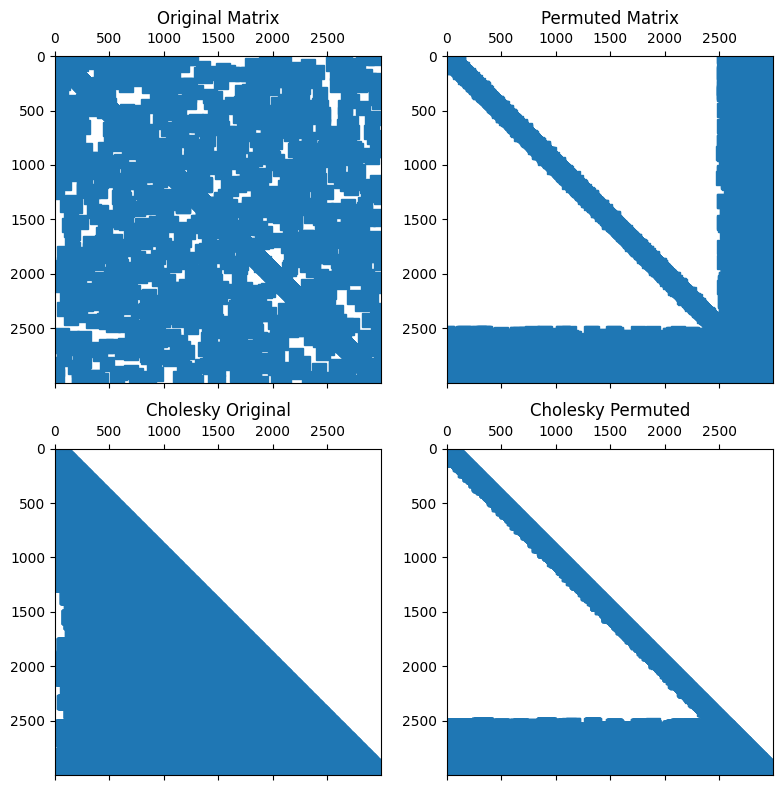

Nonzero elements in original matrix:     10198
Nonzero elements in lower-arrowhead bock form of original matrix:  10198
Nonzero elements in Cholesky L:          594968
Nonzero elements in permuted Cholesky L: 138869


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].spy(A)
axes[0,0].set_title("Original Matrix")
axes[0,1].spy(B)
axes[0,1].set_title("Permuted Matrix")
factorA = cholesky(A, ordering_method="natural")
axes[1,0].spy(factorA.L())
axes[1,0].set_title("Cholesky Original")
factorB = cholesky(B, ordering_method="natural")
axes[1,1].spy(factorB.L())
axes[1,1].set_title("Cholesky Permuted")
plt.tight_layout()
plt.show()

print('Nonzero elements in original matrix:    ', A.nnz)
print('Nonzero elements in lower-arrowhead bock form of original matrix: ', B.nnz)
print('Nonzero elements in Cholesky L:         ', factorA.L().nnz)
print('Nonzero elements in permuted Cholesky L:', factorB.L().nnz)

### Demonstration: Animation of heat distribution in a wall

Consider simulating heat distribution in a large mechanical component (e.g., a car engine block or a building wall). The thermal conduction equation is modeled using the **Heat Equation**, a PDE:

$$
\frac{\partial T}{\partial t} = \nabla \cdot (k \nabla T) + Q,
$$
where:
- $ T $: temperature,
- $ k $: thermal conductivity,
- $ Q $: heat source.

Using [Finite Element Method](https://en.wikipedia.org/wiki/Finite_element_method#:~:text=The%20finite%20element%20method%20(FEM,mass%20transport%2C%20and%20electromagnetic%20potential.) we represent continuous solid object as a set of small separate objects. Each of them transfers heat only to neighbouring pieces. Thus, if we represent temperature of all $n$ pieces in a vector $T$ we can construct $n \times n$ adjacency matrix $A$, in which each non-zero element $a_{i,j}$ represents heat conductivity between elements $i$ and $j$, and the initial equation [can be represented](https://skim.math.msstate.edu/LectureNotes/NumerPDEs_Lecture.pdf) as:
$$
AT_{t+1}=T_t
$$

To make calculations more accurate, we need to represent object with larger number $n$ of small pieces of size $1/k$. However, size of $A$ is $\mathcal{O}(k^4)$ for a 2D object and $\mathcal{O}(k^9)$ for 3D object, which may be way too large.

However, $A$ has an important feature - it is sparse, positive and symmetric. This will allow us to use sparse methods and fast Cholesky factorization for quick solution. Also, computationally-expensive computation of matrix permutation can be done only once, as adjacency matrix does not change.



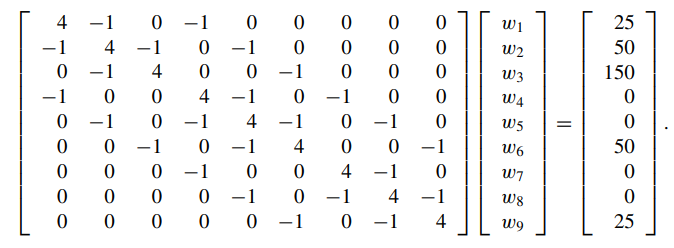

In [ ]:
def adjacency_conductivity_matrix(Nx, Ny, alpha):
    N = Nx * Ny  # Total number of nodes
    A = sp.lil_matrix((N, N))  # Initialize sparse adjacency matrix

    for i in range(Nx):
        for j in range(Ny):
            node = i * Ny + j
            if i > 0:  # Above
                neighbor = (i - 1) * Ny + j
                A[node, neighbor] = 1
            if i < Nx - 1:  # Below
                neighbor = (i + 1) * Ny + j
                A[node, neighbor] = 1
            if j > 0:  # Left
                neighbor = i * Ny + (j - 1)
                A[node, neighbor] = 1
            if j < Ny - 1:  # Right
                neighbor = i * Ny + (j + 1)
                A[node, neighbor] = 1

    I = sp.eye(Nx*Ny, format="csr")
    return (1+4*alpha)*I - alpha*A

In [ ]:
def predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames):
  lr = nested_dissection(A, 500)
  s = np.setdiff1d(np.arange(A.shape[0]), lr)
  order = np.concatenate((lr, s))
  B = A[order, :][:, order]

  cholesky_factorization = cholesky(B, ordering_method='natural')

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T[order])[np.argsort(order)]
    frames.append(T.reshape((Nx, Ny)))
  return frames

In [ ]:
Nx, Ny = 3, 3                                    # Number of grid points in x and y
alpha = 0.1
T = np.array([25, 50, 150, 0, 0, 50, 0, 0, 25])  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)
A.toarray()

array([[ 1.4, -0.1,  0. , -0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.1,  1.4, -0.1,  0. , -0.1,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.1,  1.4,  0. ,  0. , -0.1,  0. ,  0. ,  0. ],
       [-0.1,  0. ,  0. ,  1.4, -0.1,  0. , -0.1,  0. ,  0. ],
       [ 0. , -0.1,  0. , -0.1,  1.4, -0.1,  0. , -0.1,  0. ],
       [ 0. ,  0. , -0.1,  0. , -0.1,  1.4,  0. ,  0. , -0.1],
       [ 0. ,  0. ,  0. , -0.1,  0. ,  0. ,  1.4, -0.1,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.1,  0. , -0.1,  1.4, -0.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -0.1,  0. , -0.1,  1.4]])

In [ ]:
n_frames = 10
frames = predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames)

<ipython-input-24-670ab1ec6418>:11: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholesky_factorization = cholesky(B, ordering_method='natural')
100%|██████████| 10/10 [00:00<00:00, 11804.96it/s]


In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500, blit=True)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

In [ ]:
Nx, Ny = 200, 200          # Number of grid points in x and y
alpha = 0.1
T = 10*np.random.rand(Nx* Ny)  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)

In [ ]:
frames = predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames)

<ipython-input-16-30824be0102e>:15: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.14.0.
  Laplacian = nx.laplacian_matrix(G).asfptype()
<ipython-input-24-670ab1ec6418>:11: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholesky_factorization = cholesky(B, ordering_method='natural')
100%|██████████| 10/10 [00:00<00:00, 34.06it/s]


In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

### Task 3 (5 pts):
Compare computation and memory efficiency of Cholesky using intact matrix with your implementation of Nested Dissection with built-in method.

In [ ]:
from time import time

In [ ]:
def predict_heat_distribution_naive(A, T, Nx, Ny, n_frames):
  cholesky_factorization = cholesky(A)

  frames = [T.copy().reshape((Nx, Ny))]

  times = []
  for _ in tqdm(range(n_frames)):
    start_time = time()
    T = factor.solve_A(T)
    frames.append(T.reshape((Nx, Ny)))
    finish_time = time()
    times.append(finish_time - start_time)
  return frames, times

In [ ]:
def predict_heat_distribution(A, T, Nx, Ny, n_frames):
  cholesky_factorization = cholesky(A)

  frames = [T.copy().reshape((Nx, Ny))]
  times = []
  for _ in tqdm(range(n_frames)):
    start_time = time()
    T = cholesky_factorization.solve_A(T)
    frames.append(T.reshape((Nx, Ny)))
    finish_time = time()
    times.append(finish_time - start_time)
  return frames, times

In [ ]:
# added time computation
def predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames):
  lr = nested_dissection(A, 500)
  s = np.setdiff1d(np.arange(A.shape[0]), lr)
  order = np.concatenate((lr, s))
  B = A[order, :][:, order]
  cholesky_factorization = cholesky(B, ordering_method='natural')
  frames = [T.copy().reshape((Nx, Ny))]
  times = []
  for _ in tqdm(range(n_frames)):
    start_time = time()
    T = cholesky_factorization.solve_A(T[order])[np.argsort(order)]
    frames.append(T.reshape((Nx, Ny)))
    finish_time  = time()
    times.append(finish_time - start_time)
  return frames, times

In [ ]:
factor = cholesky(A, ordering_method='natural')
Nx, Ny = 200, 200          # Number of grid points in x and y
alpha = 0.1
T = 10*np.random.rand(Nx* Ny)  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)
A.toarray()

<ipython-input-98-7332e26d11d0>:1: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(A, ordering_method='natural')


array([[ 1.4, -0.1,  0. , ...,  0. ,  0. ,  0. ],
       [-0.1,  1.4, -0.1, ...,  0. ,  0. ,  0. ],
       [ 0. , -0.1,  1.4, ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  1.4, -0.1,  0. ],
       [ 0. ,  0. ,  0. , ..., -0.1,  1.4, -0.1],
       [ 0. ,  0. ,  0. , ...,  0. , -0.1,  1.4]])

In [ ]:
frames_naive, times_naive = predict_heat_distribution_naive(A, T, Nx, Ny, n_frames)
frames_built_in, times_built_in = predict_heat_distribution(A, T, Nx, Ny, n_frames)
homemade_frames, homemade_times = predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames)

<ipython-input-95-148f57425e39>:2: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholesky_factorization = cholesky(A)
100%|██████████| 10/10 [00:00<00:00, 122.76it/s]
<ipython-input-16-30824be0102e>:15: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.14.0.
  Laplacian = nx.laplacian_matrix(G).asfptype()
<ipython-input-97-cddb02ac5876>:6: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholesky_factorization = cholesky(B, ordering_method='natural')
100%|██████████| 10/10 [00:00<00:00, 64.59it/s]


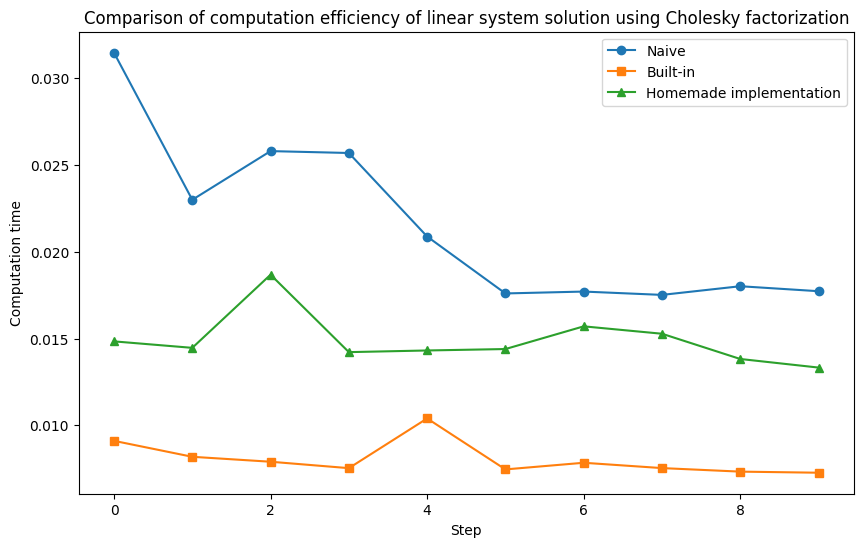

In [ ]:
x = range(n_frames)
plt.figure(figsize=(10, 6))
plt.plot(x, times_naive, label='Naive', marker='o')
plt.plot(x, times_built_in, label='Built-in', marker='s')
plt.plot(x, homemade_times, label='Homemade implementation', marker='^')


plt.title('Comparison of computation efficiency of linear system solution using Cholesky factorization')
plt.xlabel('Step')
plt.ylabel('Computation time')
plt.legend()
plt.show()

In [ ]:
factor_naive = cholesky(A, ordering_method='natural')
print(factor_naive.L().nnz)

factor_built_in = cholesky(A)
print(factor_built_in.L().nnz)

lr = nested_dissection(A, 500)
s = np.setdiff1d(np.arange(A.shape[0]), lr)
order = np.concatenate((lr, s))
B = A[order, :][:, order]
homemade_factor = cholesky(B, ordering_method="natural")
print(homemade_factor.L().nnz)

<ipython-input-87-13669989e282>:1: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor_naive = cholesky(A, ordering_method='natural')


8874986
1603752


<ipython-input-87-13669989e282>:4: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor_built_in = cholesky(A)
<ipython-input-16-30824be0102e>:15: DeprecationWarning: `asfptype` is an internal function, and is deprecated as part of the public API. It will be removed in v1.14.0.
  Laplacian = nx.laplacian_matrix(G).asfptype()
<ipython-input-87-13669989e282>:11: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  homemade_factor = cholesky(B, ordering_method="natural")


3423876


Memory is correlated with non-zero elements, so our homemade method better then naive but worse then build-in method

## Clusterisation of musical notes with FFT and PCA (10 pts)

A [link](https://drive.google.com/drive/folders/11Nvytewu8_QAWOTPGkfDD0bl9j5lb8Ee?usp=sharing) to the wav files.

In [ ]:
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

### Implement FFT via Cooley-Tukey (check lectures) (5 pts)

I implemented FFT for x with input of size 2**n and slightly changed process_audio function (added cycle). Another way was make cycle in FFT but I think that this way more difficult (because of problems with recursion)

In [ ]:
def FFT(x):
    """
    1D Cooley-Tukey FFT implementation for input of size 2**n.
    """
    N = len(x)

    # Base case: if the input size is 1, return the input
    if N <= 1:
        return x

    # Split the input into even and odd parts
    even = FFT(x[0::2])  # FFT of even indexed elements
    odd = FFT(x[1::2])   # FFT of odd indexed elements

    # Combine the results
    T = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
    return [even[k] + T[k] for k in range(N // 2)] + [even[k] - T[k] for k in range(N // 2)]

### PCA (use SVD library func) (5 pts)

In [ ]:
# def calc_PCA(matrix, n_components):
#     # as input: matrix (n_samples, n_features)
#     # as output: matrix (n_samples, n_features)

#     '''
#     replace with your own func!
#     '''

#     from sklearn.decomposition import PCA
#     a = PCA(n_components)
#     return a.fit_transform(matrix)


def calc_PCA(matrix, n_components):
    # Center the data by subtracting the mean
    mean = np.mean(matrix, axis=0)
    centered_matrix = matrix - mean

    # Perform Singular Value Decomposition
    U, S, Vt = np.linalg.svd(centered_matrix, full_matrices=False)

    # Select the first n_components
    principal_components = Vt[:n_components]

    # Project the data onto the principal components
    transformed_data = np.dot(centered_matrix, principal_components.T)

    return transformed_data

### Read files + Utils

In [ ]:
def process_audio(filename):
    samplerate, data = wavfile.read(f'./{filename}.wav')
    if len(data.shape) > 1:
        # convert to mono
        data = data[:, 0]

    data_splitted = []

    w_size = 2048
    for indent in [0, 512, 1024, 1024 + 512]:
        data_i = data[indent:]
        data_i = data_i[:data_i.shape[0] - data_i.shape[0] % w_size]
        n_splits = data_i.shape[0] // w_size
        # print(data.shape)
        data_splitted.append(np.split(data_i, n_splits))

    data_splitted = np.concatenate(data_splitted)
    # print('len of array', len(data_splitted))
    # print(data_splitted)
    # print(len(data_splitted[5]))

    a = []
    for i in data_splitted:
        a.append(FFT(i))
    a = np.array(a)
    # a = FFT(data_splitted)
    a = a / np.linalg.norm(a, axis=1).reshape(-1, 1)
    return a, [filename] * a.shape[0]

In [ ]:
chunks, labels = [], []

for fl in ['a1', 'b1', 'c1', 'e1', 'f1', 'g1', 'a1s', 'c1s', 'd1s', 'f1s', 'g1s']:
    z, x = process_audio(fl)
    chunks.append(z)
    labels.append(x)



In [ ]:
labels_concat = []
for l in labels:
    labels_concat += l

In [ ]:
chunks_np = np.abs(np.concatenate(chunks))

In [ ]:
chunks_fitted = calc_PCA(chunks_np, 4)

### Visualisation

In [ ]:
colors = {
    'a1': 'red',
    'a1s': 'pink',
    'b1': 'green',
    'c1': 'blue',
    'c1s': 'olive',
    'd1s': 'purple',
    'e1': 'cyan',
    'f1': 'orange',
    'f1s': 'black',
    'g1': 'yellow',
    'g1s': 'blueviolet',

}
color_labels = [colors[d] for d in labels_concat]

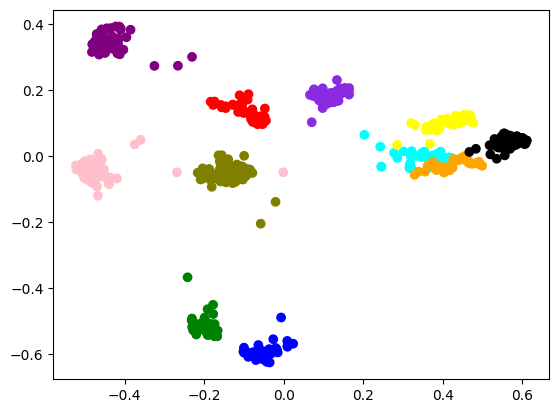

In [ ]:
plt.scatter(chunks_fitted[:, 0], chunks_fitted[:, 3], color=color_labels)

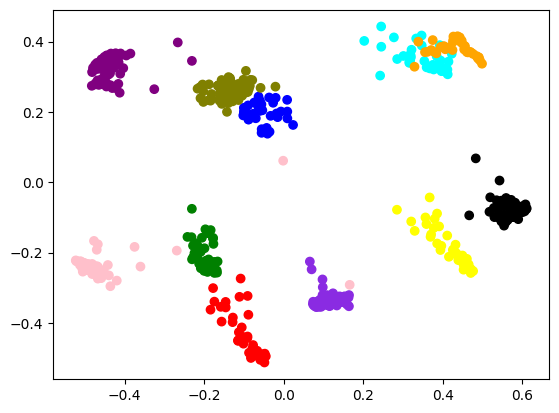

In [ ]:
plt.scatter(chunks_fitted[:, 0], chunks_fitted[:, 2], color=color_labels)